<a href="https://colab.research.google.com/github/KaiSan2001/DeepLearning_StudyLibrary/blob/main/SRCNN/Pre_operation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Library Initialization#
#Import Required Packages#
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from PIL import Image
import numpy as np
Path = '/content/drive/MyDrive/Deeplearning/SRCNNUS'
print(os.getcwd())
os.chdir(Path)
!ls
print(os.getcwd())

/content
Cropped  DataPrep.ipynb  Pre-operation.ipynb  Test  Train
/content/drive/MyDrive/Deeplearning/SRCNNUS


In [71]:
#Metric Declaration#
#Define Signal-to-Noise Ratio (PSNR)
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = np.sqrt(np.mean(diff ** 2.))
    return 20 * np.log10(255. / rmse)

#Define Mean Squared Error
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

#Define Structural Similarity#
from skimage.metrics import structural_similarity as ssim
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

In [72]:
#Comparison Trial#
target = cv2.imread(Path+'/Test/groundTruth/1.jpg')
ref = cv2.imread(Path+'/Test/Input/1.jpg')

metrics = compare_images(target, ref)
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

PSNR: 22.55160738098808
MSE: 1084.0288908634006
SSIM: 0.5021217110704037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [3]:
image = Image.open(Path+'/Test/groundTruth/1.jpg')
image = np.array(image)
print(image.shape)
image = image[100:612,:]
print(image.shape)
image_aug = np.zeros((512,512,3), dtype = float) 
image_aug[:,:511,:]=image[:,:,:]
print(image_aug.shape)

(718, 511, 3)
(512, 511, 3)
(512, 512, 3)


In [47]:
#Data Pre-cropping#

#GroundTruth Cropping#
os.chdir(Path+'/Cropped/groundTruth')
GT = sorted(os.listdir(Path+'/Test/groundTruth'))
nums1 = len(GT)
data_GT = np.zeros((nums1,512,512,1),dtype=np.float)
for i, name1 in enumerate(GT):
    fpath1 = Path+'/Test/groundTruth/' + name1
    image = Image.open(fpath1)
    image = np.array(image)
    image = image[100:612,:]
    image = Image.fromarray(image)

    image.save('%s'%name1)

#Input Cropping#
os.chdir(Path+'/Cropped/Input')
GT = sorted(os.listdir(Path+'/Test/Input'))
nums1 = len(GT)
data_GT = np.zeros((nums1,512,512,1),dtype=np.float)
for i, name2 in enumerate(GT):
    fpath2 = Path+'/Test/Input/' + name2
    image = Image.open(fpath2)
    image = np.array(image)
    image = image[100:612,:]
    image = Image.fromarray(image)

    image.save('%s'%name2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [50]:
#Training Set Operation#
import h5py
TrainPath = Path +'/Cropped'
Input_set = []
groundTruth_set = []

#Output operation#
GTs = sorted(os.listdir(TrainPath+'/groundTruth'))
for gt in GTs:
    fpath1 = TrainPath + '/groundTruth/' + gt #Read in the file one by one
    gt_img = cv2.imread(fpath1, cv2.IMREAD_COLOR)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2YCrCb)
    gt_img = gt_img[:,:,0]
    shape = gt_img.shape
    #print(shape)

    #find the corresponding Input image
    fpath2 = TrainPath +'/Input/' + gt
    Input_img = cv2.imread(fpath2, cv2.IMREAD_COLOR)
    Input_img = cv2.cvtColor(Input_img, cv2.COLOR_BGR2YCrCb)
    Input_img = Input_img[:,:,0]

    width_range = int((shape[0] - 16 * 2) / 16)
    height_range = int((shape[1] - 16 * 2) / 16)
    
    for k in range(width_range):
        for j in range(height_range):
            x = k * 16
            y = j * 16
            
            gt_patch = gt_img[x: x + 32, y: y + 32]
            Input_patch = Input_img[x: x + 32, y: y + 32]
            
            gt_patch = gt_patch.astype(np.float32) / 255.
            Input_patch = Input_patch.astype(np.float32) / 255.
            
            groundTruth = np.zeros((1, 20, 20), dtype=np.double)
            Input = np.zeros((1, 32, 32), dtype=np.double)
            
            groundTruth[0, :, :] = gt_patch[6:-6, 6: -6]
            Input[0, :, :] = Input_patch
            
            groundTruth_set.append(groundTruth)
            Input_set.append(Input)

Input_set = np.array(Input_set, dtype=np.float32)
groundTruth_set = np.array(groundTruth_set, dtype=np.float32)
print(groundTruth_set.shape)

(8700, 1, 20, 20)


In [51]:
os.chdir(Path+'/Cropped')
with h5py.File('train.h5', 'w') as h:
  h.create_dataset('Input', data = Input_set, shape = Input_set.shape)
  h.create_dataset('groundTruth', data = groundTruth_set, shape = groundTruth_set.shape)

In [52]:
#Model Initialization#
# Define the SR-CNN model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9), 
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN
srcnn_model = model()
srcnn_model.summary()


Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, None, None, 128)   10496     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [53]:
with h5py.File('./train.h5', 'r') as h:
    data = np.array(h.get('Input'))
    label = np.array(h.get('groundTruth'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    print(data.shape)
    print(label.shape)
    y_train = np.transpose(label, (0, 2, 3, 1))


X_test = X_train; y_test = y_train
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8700, 1, 32, 32)
(8700, 1, 20, 20)


((8700, 32, 32, 1), (8700, 20, 20, 1), (8700, 32, 32, 1), (8700, 20, 20, 1))

In [54]:
checkpoint_path = './srcnn/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True,
                                                 save_weights_only=True, verbose=0)

In [55]:
srcnn_model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), 
                callbacks=[checkpoint], shuffle=True, epochs=5, verbose=False)

In [56]:
print(Path)

/content/drive/MyDrive/Deeplearning/SRCNNUS


In [107]:
#Post Processing#

Target = cv2.imread(Path+'/Cropped/Input/1.jpg',cv2.IMREAD_COLOR)
Target = cv2.cvtColor(Target, cv2.COLOR_BGR2YCrCb)
shape = Target.shape
Y = np.zeros((1, Target.shape[0], Target.shape[1], 1), dtype=np.float32)

Y[0,:,:,0] = Target[:,:,1].astype(np.float32) / 255.

#Prediction#
pre =  srcnn_model.predict(Y, batch_size=1) * 255

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)
# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(Target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6,0] = pre[0,:, :,0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

#Save Image#
cv2.imwrite(Path+'/Cropped/Output/Output1.jpg', output)


True

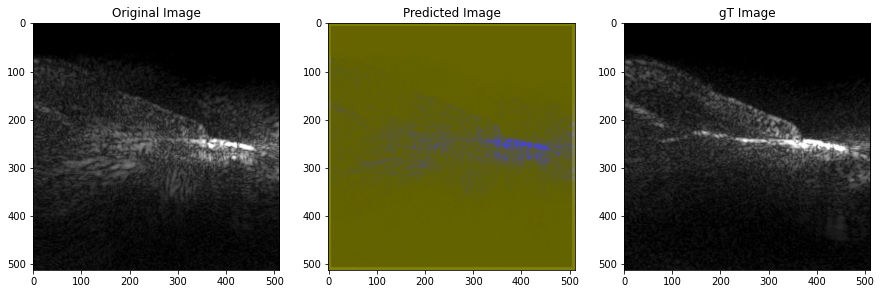

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open(Path+'/Cropped/Input/1.jpg'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open(Path+'/Cropped/Output/Output1.jpg'))
ax[1].title.set_text("Predicted Image")

ax[2].imshow(Image.open(Path+'/Cropped/groundTruth/1.jpg'))
ax[2].title.set_text("gT Image")

In [109]:
#Comparison#
original_img = cv2.imread(Path+'/Cropped/Input/1.jpg')
predict_img = cv2.imread(Path+'/Cropped/Output/Output1.jpg')
GT_img = cv2.imread(Path+'/Cropped/groundTruth/1.jpg')

metrics = compare_images(original_img, GT_img)
print("Metrics for original and groundTruth image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

metrics = compare_images(GT_img, predict_img)
print("Metrics for groundTruth and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Metrics for original and groundTruth image
PSNR: 22.57135263248231
MSE: 1079.111668297456
SSIM: 0.4670128857754578
Metrics for groundTruth and predicted image
PSNR: 11.361676671288885
MSE: 14257.189823874756
SSIM: 0.20900506343857064
